In [1]:
import util
import plotting
import evaluation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
from tqdm import tqdm

import tensorflow as tf

In [2]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load model and test data

#### No preprocessing, different batch sizes

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [4]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'ref')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/model.h5

Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/ref_f8_c9_b32/model.h5

Loading H:/Santi/Models/ref_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/history

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/ref_f8_c9_b32/history

Loading H:/Santi/Models/ref_f8_c9_b256/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/frames_test

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/ref_f8_c9_b32/frames_test

Loading H:/Santi/Models/ref_f8_c9_b256/frames_test
Done.


In [5]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: ref_f8_c9_b8


 25%|████████████████                                                | 1/4 [00:08<00:24,  8.15s/it]


Model: ref_f8_c9_b16


 50%|████████████████████████████████                                | 2/4 [00:12<00:14,  7.05s/it]


Model: ref_f8_c9_b32


 75%|████████████████████████████████████████████████                | 3/4 [00:17<00:06,  6.31s/it]


Model: ref_f8_c9_b256


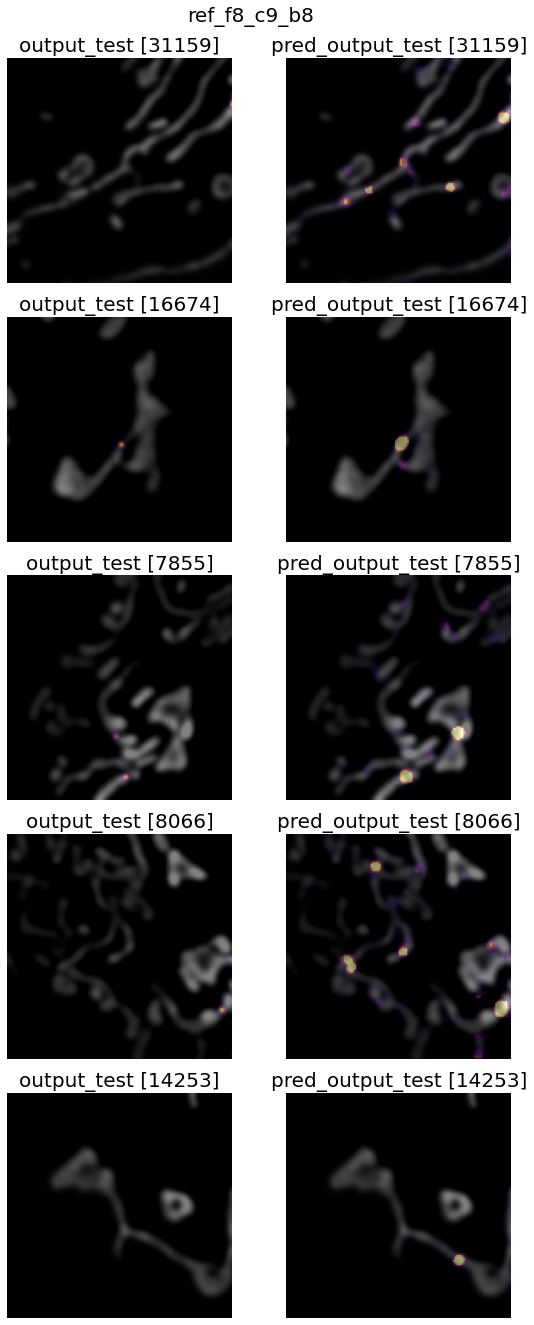

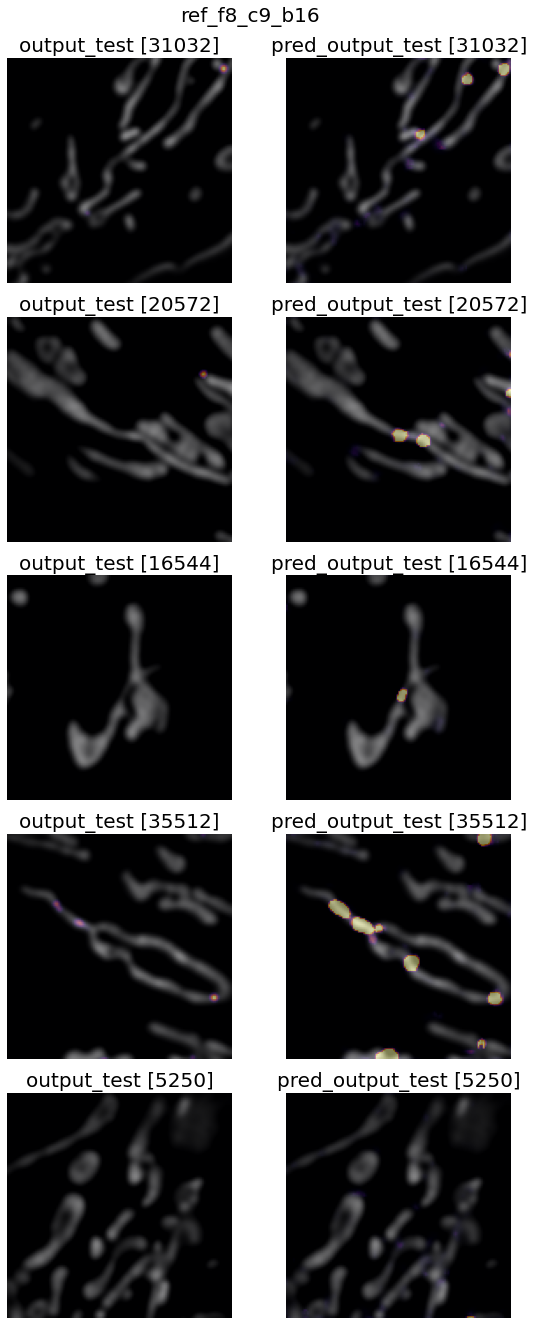

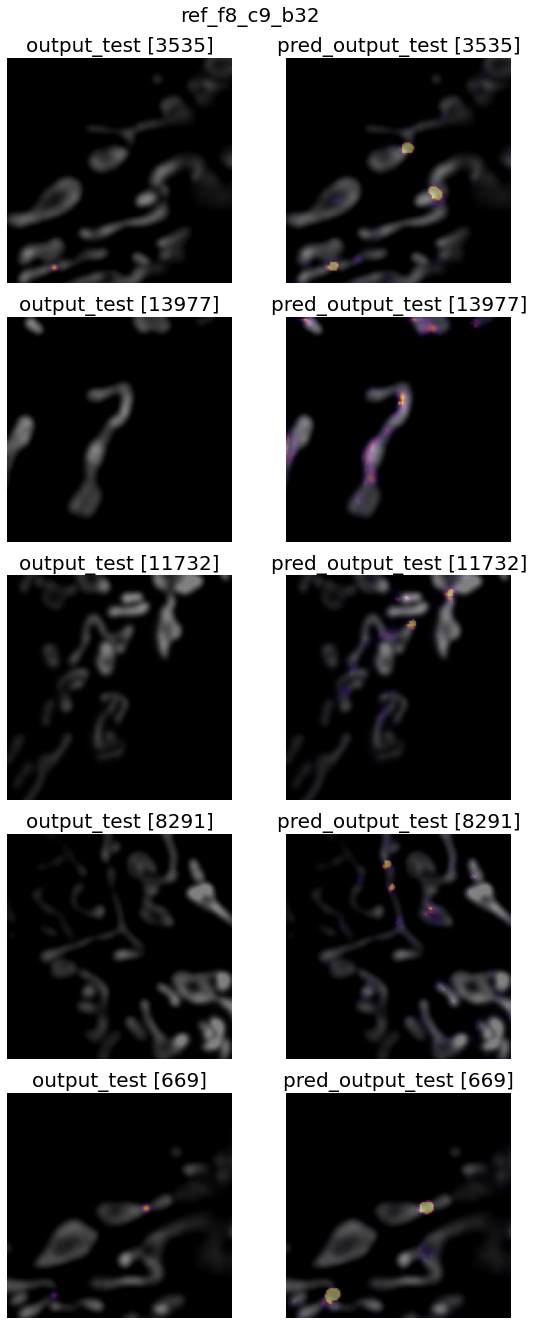

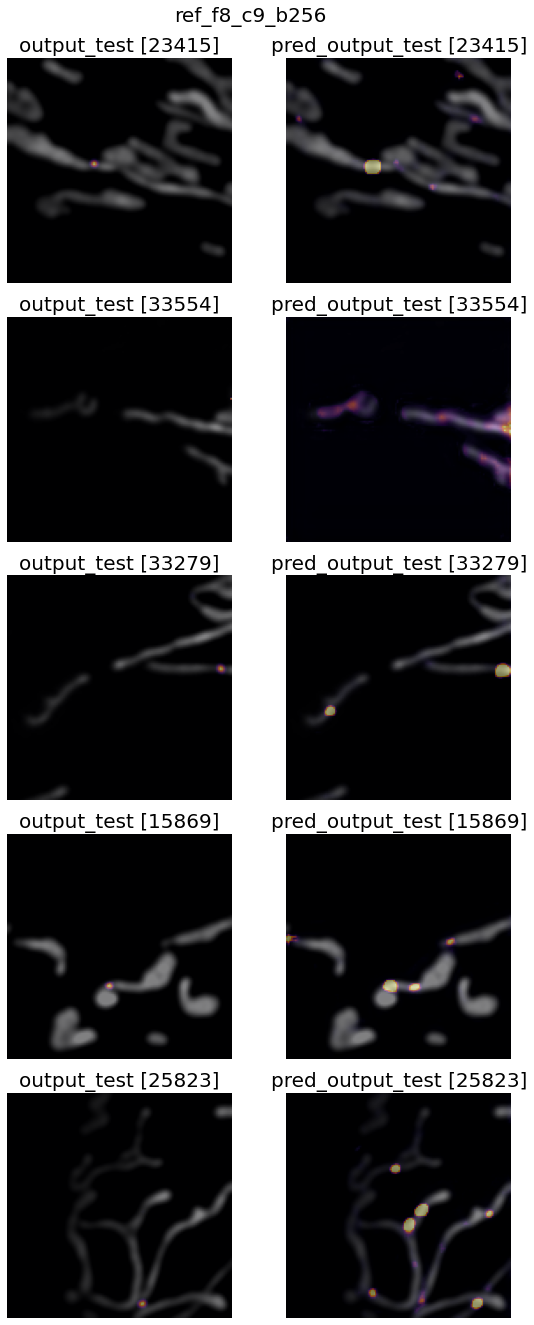

In [7]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [ ]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(model), folder_name)

In [8]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(model), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/metrics

Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/ref_f8_c9_b32/metrics

Loading H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


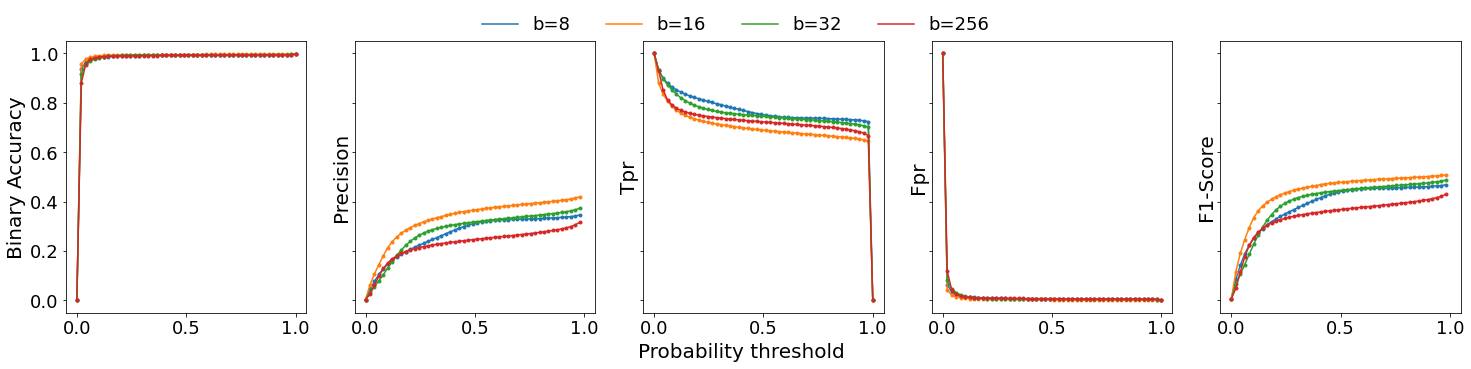

In [9]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name.title())
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)
plt.show()

##### metricAtMaxThreshold

In [10]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b8  ref_f8_c9_b16  ref_f8_c9_b32  ref_f8_c9_b256
binary accuracy      0.994731       0.996018       0.995367        0.994197
precision            0.345865       0.419817       0.372975        0.316267
TPR                  0.723543       0.645070       0.700927        0.667311
FPR                  0.004397       0.002857       0.003707        0.004731
F1-score             0.468013       0.508620       0.486875        0.429144

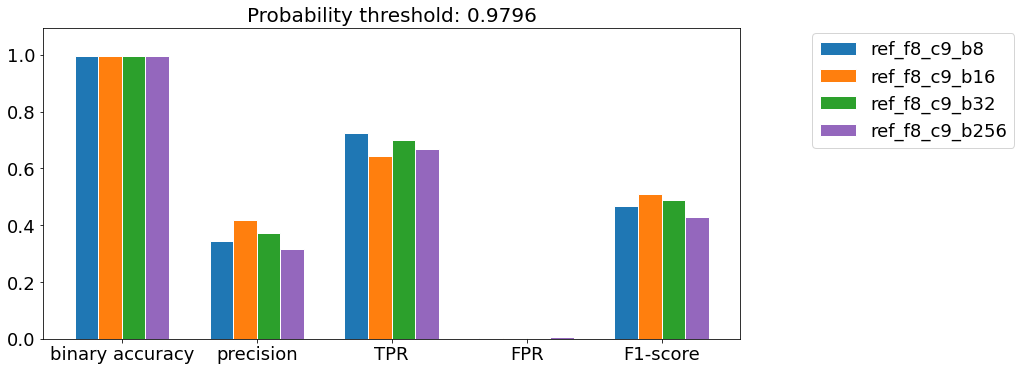

In [11]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

#### MitoProc, different batch sizes

In [12]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [15]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'mp')
folder_name = [model_name for model_name in folder_name if '_s' not in model_name]
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b32/model.h5

Loading H:/Santi/Models/mp_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/history

Loading H:/Santi/Models/mp_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b32/history

Loading H:/Santi/Models/mp_f8_c9_b256/history
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b32/frames_test

Loading H:/Santi/Models/mp_f8_c9_b256/frames_test
Done.


In [16]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: mp_f8_c9_b8


 25%|████████████████                                                | 1/4 [00:04<00:12,  4.21s/it]


Model: mp_f8_c9_b16


 50%|████████████████████████████████                                | 2/4 [00:08<00:08,  4.31s/it]


Model: mp_f8_c9_b32


 75%|████████████████████████████████████████████████                | 3/4 [00:13<00:04,  4.30s/it]


Model: mp_f8_c9_b256


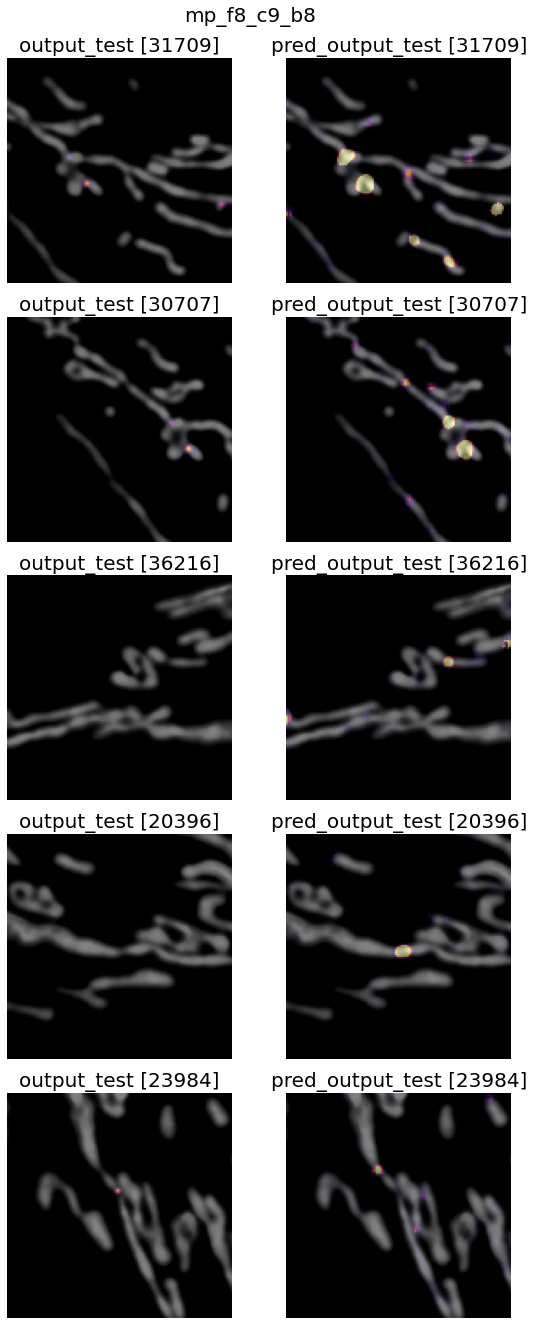

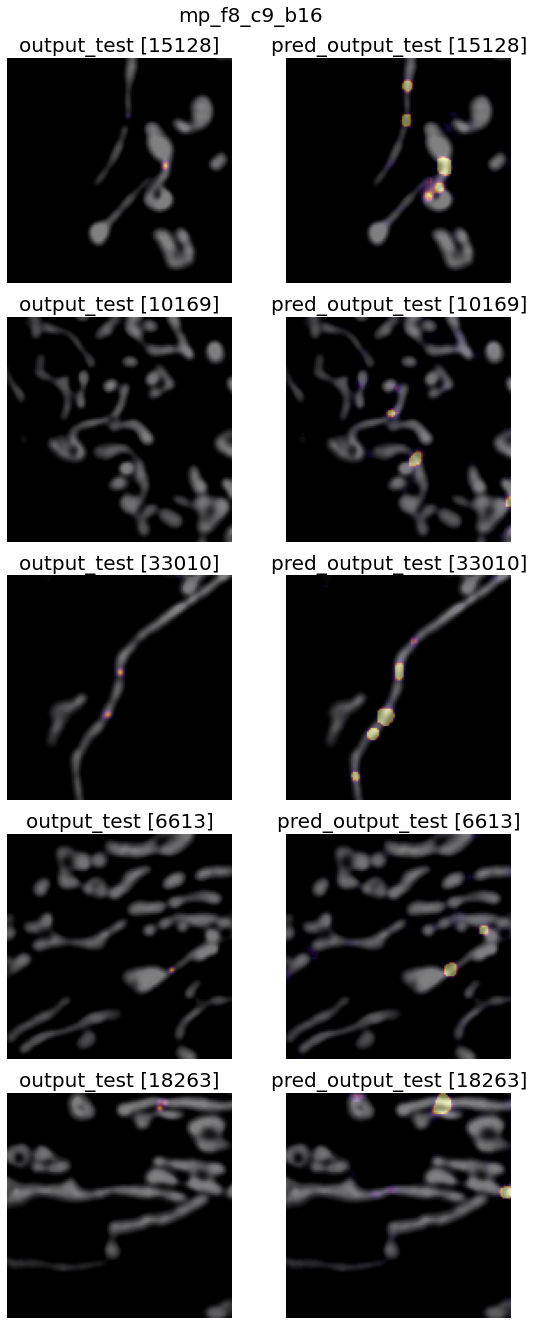

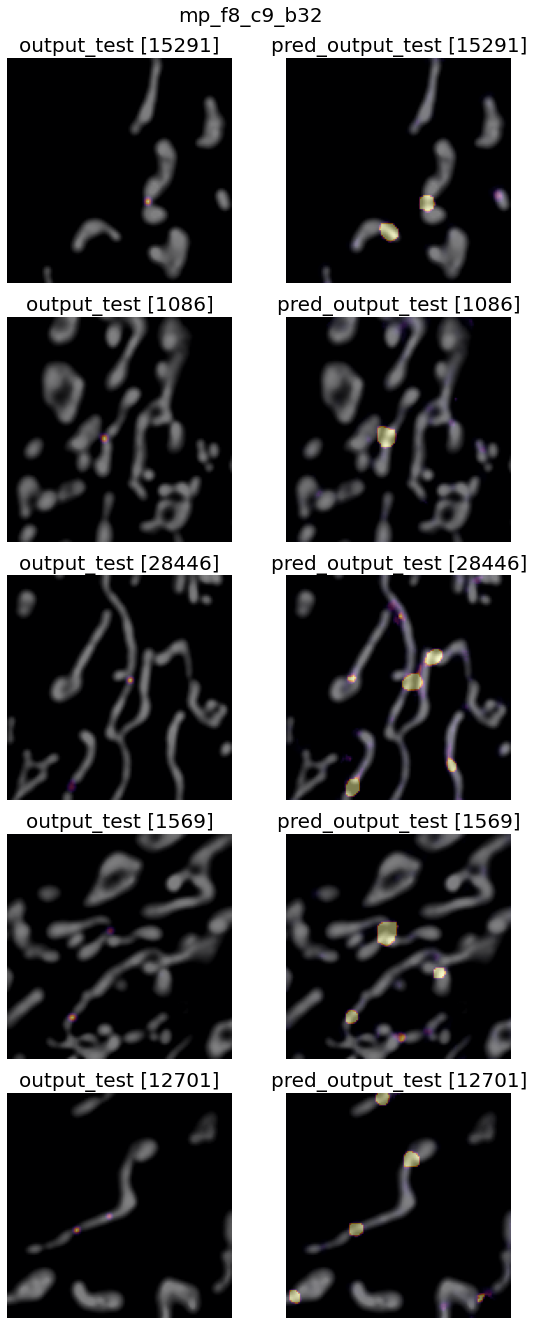

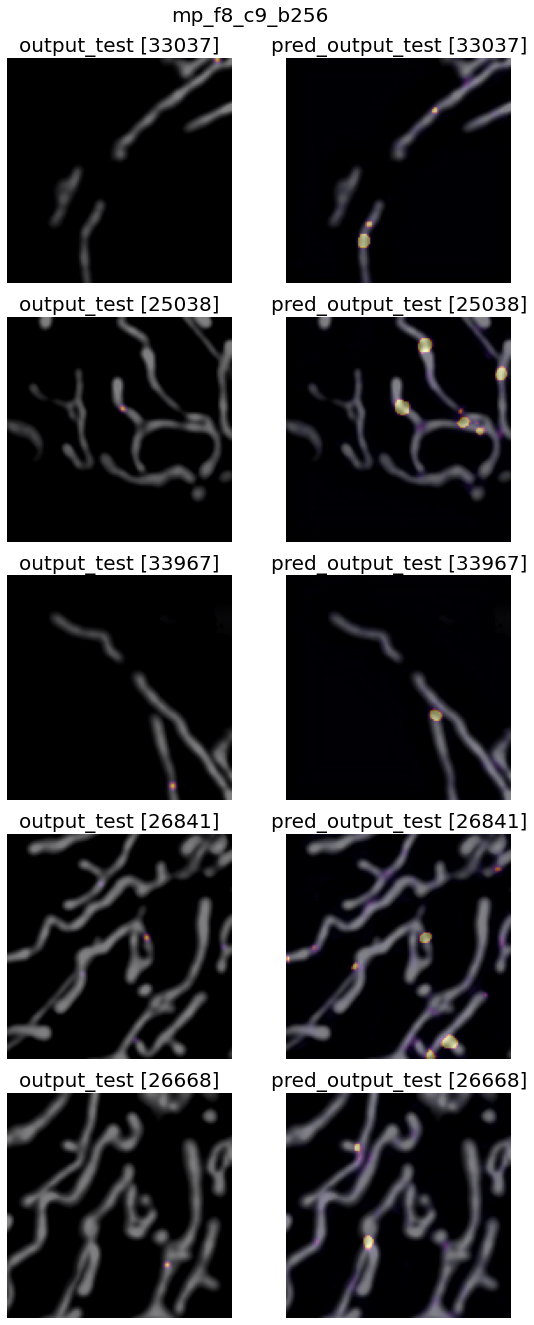

In [17]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [18]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

mp_f8_c9_b8: 0.75


C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


mp_f8_c9_b16: 0.77


mp_f8_c9_b32: 0.72


mp_f8_c9_b256: 0.74



Saving H:/Santi/Models/mp_f8_c9_b8/metrics

Saving H:/Santi/Models/mp_f8_c9_b16/metrics

Saving H:/Santi/Models/mp_f8_c9_b32/metrics

Saving H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


In [18]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b32/metrics

Loading H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


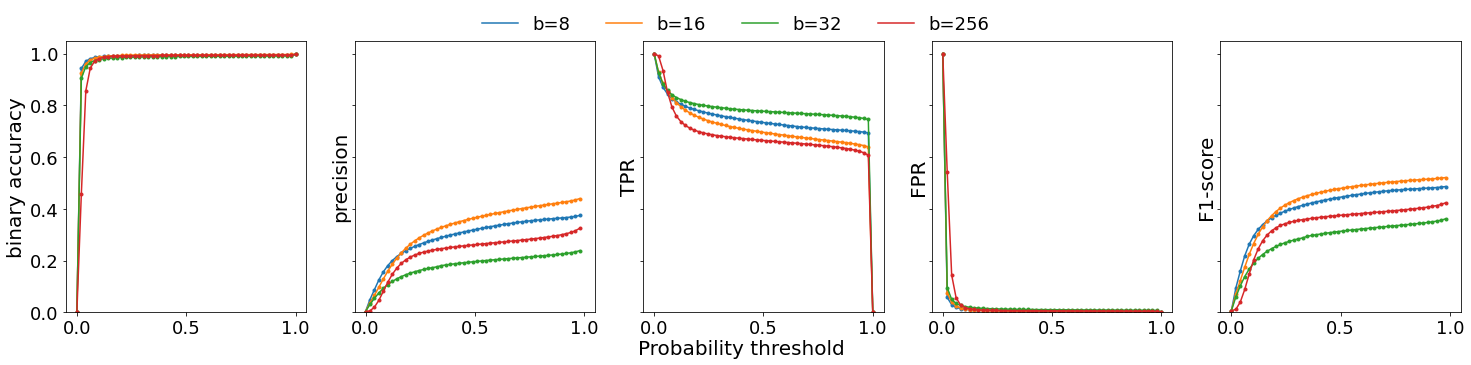

In [19]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0.01, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)

plt.show()

##### metricAtMaxThreshold

In [20]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

mp_f8_c9_b8  mp_f8_c9_b16  mp_f8_c9_b32  mp_f8_c9_b256
binary accuracy     0.995174      0.996322      0.991400       0.994677
precision           0.374470      0.439567      0.238522       0.324960
TPR                 0.693245      0.639223      0.745263       0.607050
FPR                 0.003828      0.002557      0.007793       0.004072
F1-score            0.486271      0.520919      0.361383       0.423315

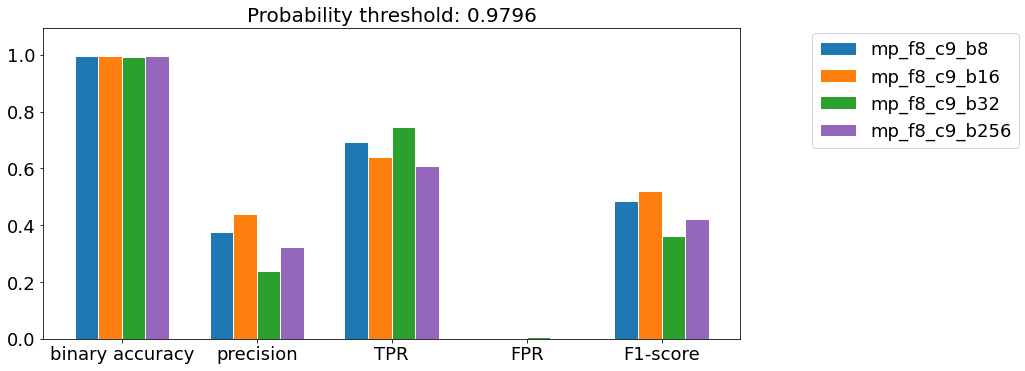

In [21]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

#### MitoProc vs Mito, batch_size=16

In [27]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [28]:
model_path = base_dir + 'Models/'
batch_size = 16
folder_name = ['ref_f8_c9_b%i'%batch_size, 'mp_f8_c9_b%i'%batch_size]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b16/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test
Done.


In [29]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                        | 0/2 [00:00<?, ?it/s]


Model: ref_f8_c9_b16


 50%|████████████████████████████████                                | 1/2 [00:04<00:04,  4.27s/it]


Model: mp_f8_c9_b16


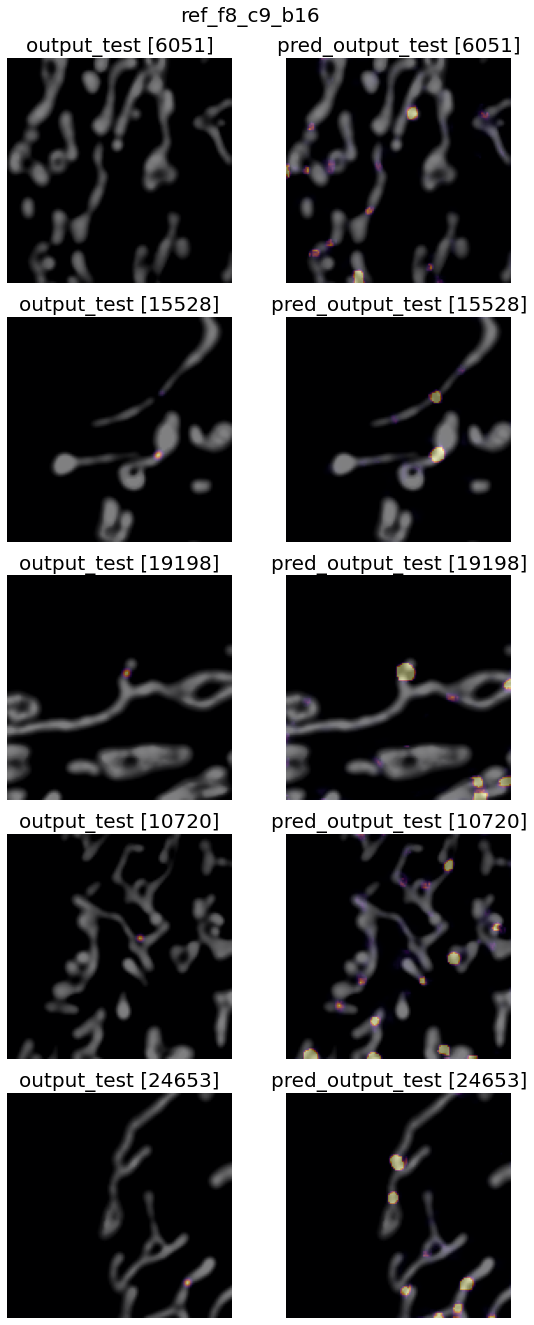

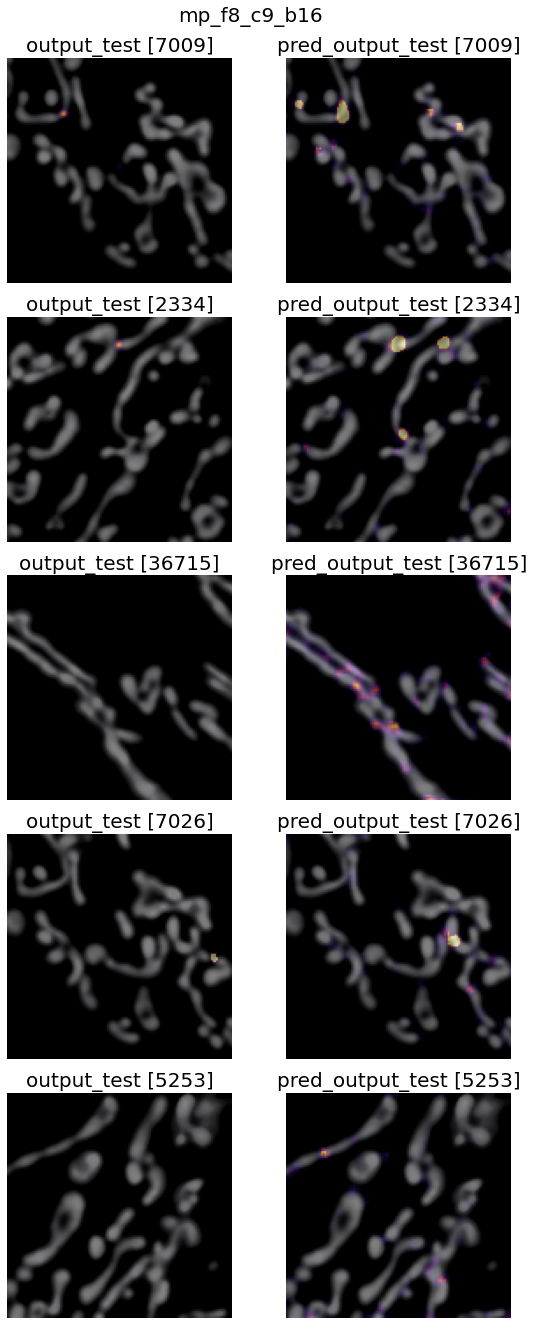

In [30]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [31]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics
Done.


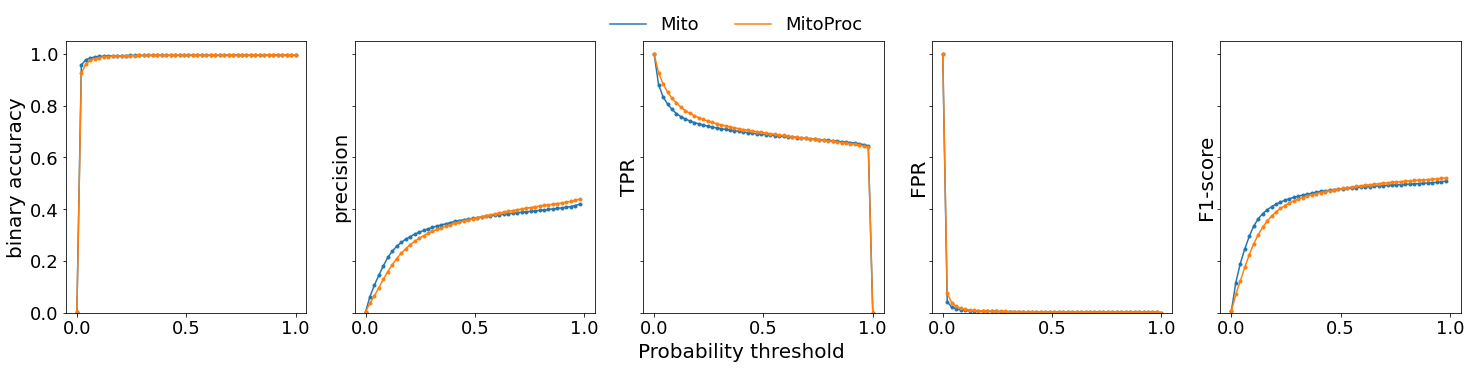

In [32]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['Mito', 'MitoProc'],
           loc='upper center', ncol=4, framealpha=0)

plt.show()

##### metricAtMaxThreshold

In [33]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b16  mp_f8_c9_b16
binary accuracy       0.996018      0.996322
precision             0.419817      0.439567
TPR                   0.645070      0.639223
FPR                   0.002857      0.002557
F1-score              0.508620      0.520919

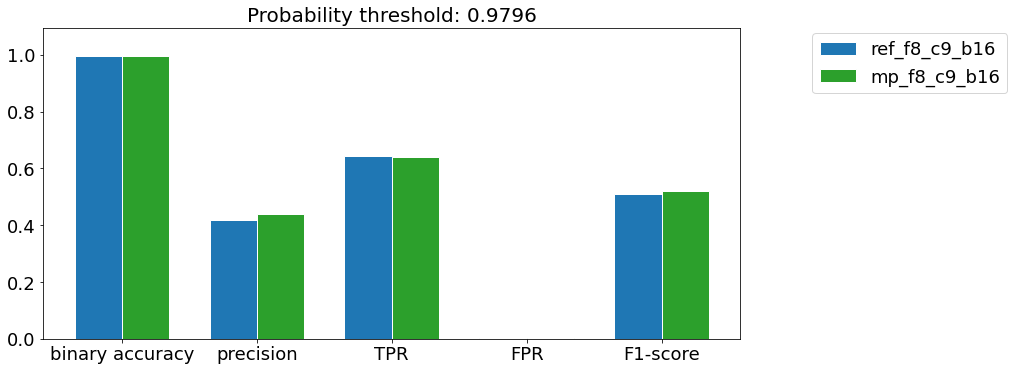

In [34]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

#### Proc & WatProc, different spot sizes

In [18]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

sigmas = np.arange(0.5, 2+0.5, 0.5)
nb_sigmas = sigmas.shape[0]

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp')
folder_name = [model_name for model_name in folder_name if 'mp' not in model_name]

output_data = {}

for model_name, s in zip(folder_name, sigmas):
  #Outputs
  output_data[model_name] = util.load_h5(data_path, 'WatProc_s'+str(s))

print('Outputs:', output_data[folder_name[0]].shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/WatProc_s0.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.0.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s2.0.h5
Converting to array
Outputs: (37000, 128, 128)


In [19]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s0.5/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s1.0/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s1.5/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.0/model.h5
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s0.5/history

Loading H:/Santi/Models/wp_f8_c9_b16_s1.0/history

Loading H:/Santi/Models/wp_f8_c9_b16_s1.5/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.0/history
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s0.5/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s1.0/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s1.5/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.0/frames_test
Done.


In [20]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[model_name][frames_test[model_name]]
  del output_data[model_name]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
del input_data

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: wp_f8_c9_b16_s0.5


 25%|████████████████                                                | 1/4 [00:02<00:08,  2.88s/it]


Model: wp_f8_c9_b16_s1.0


 50%|████████████████████████████████                                | 2/4 [00:05<00:05,  2.87s/it]


Model: wp_f8_c9_b16_s1.5


 75%|████████████████████████████████████████████████                | 3/4 [00:08<00:02,  2.88s/it]


Model: wp_f8_c9_b16_s2.0


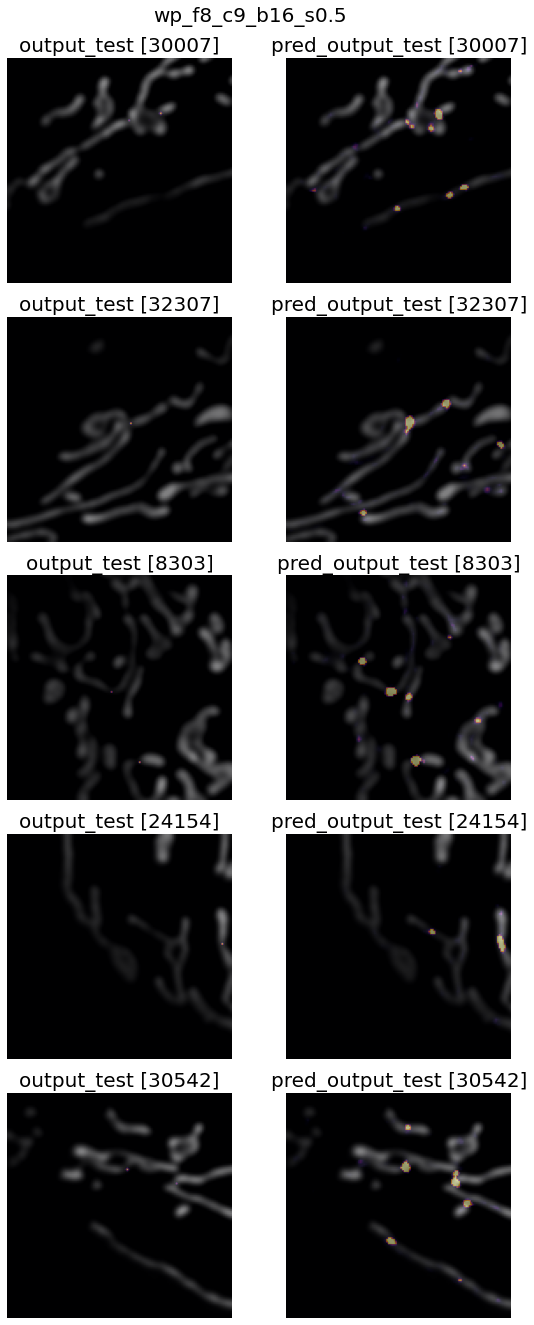

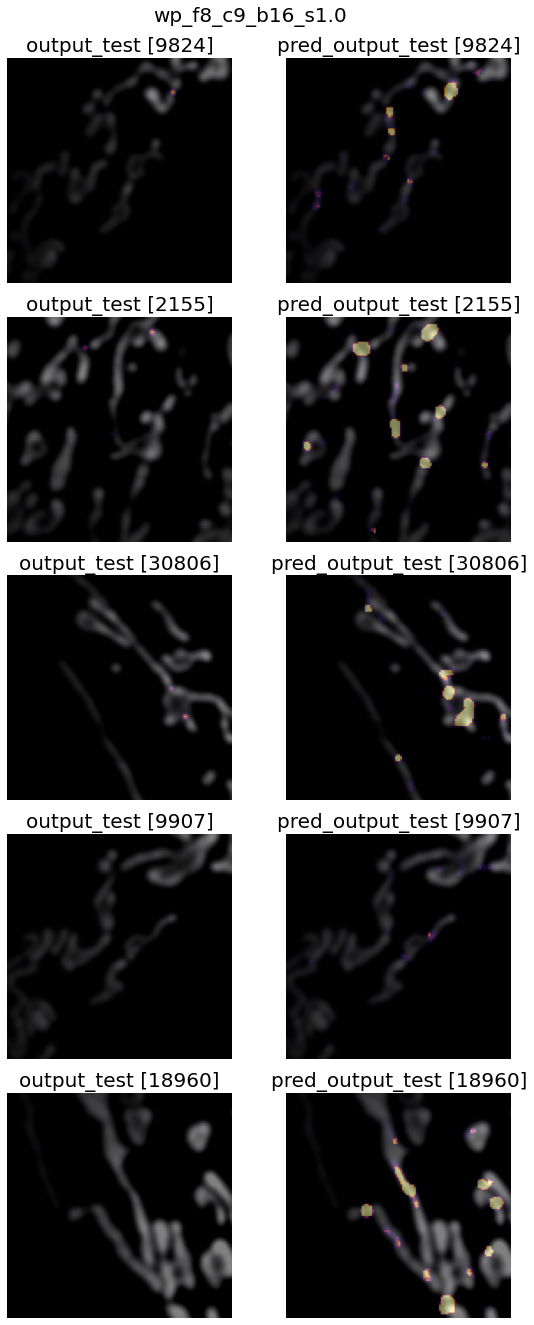

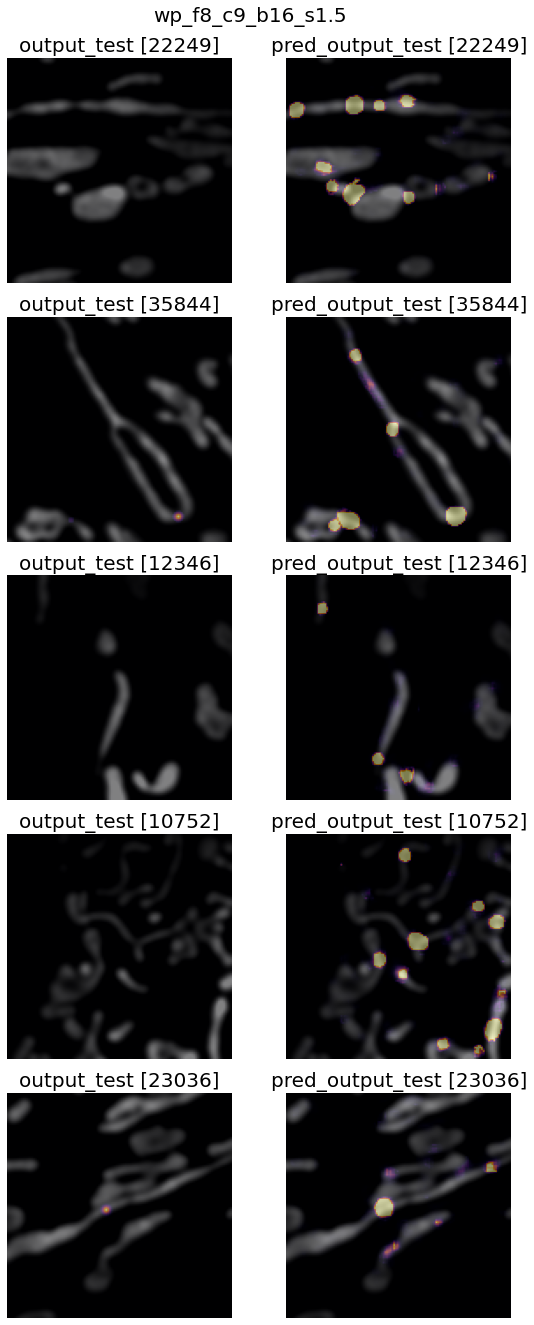

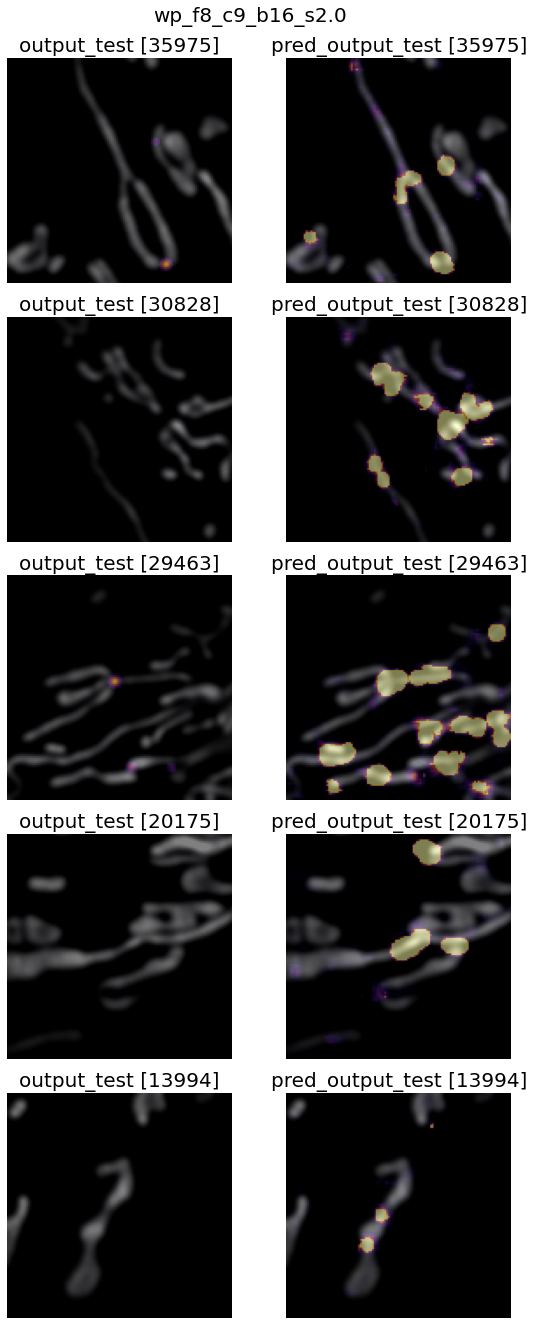

In [21]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [ ]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

In [22]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s0.5/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s1.0/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s1.5/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.0/metrics
Done.


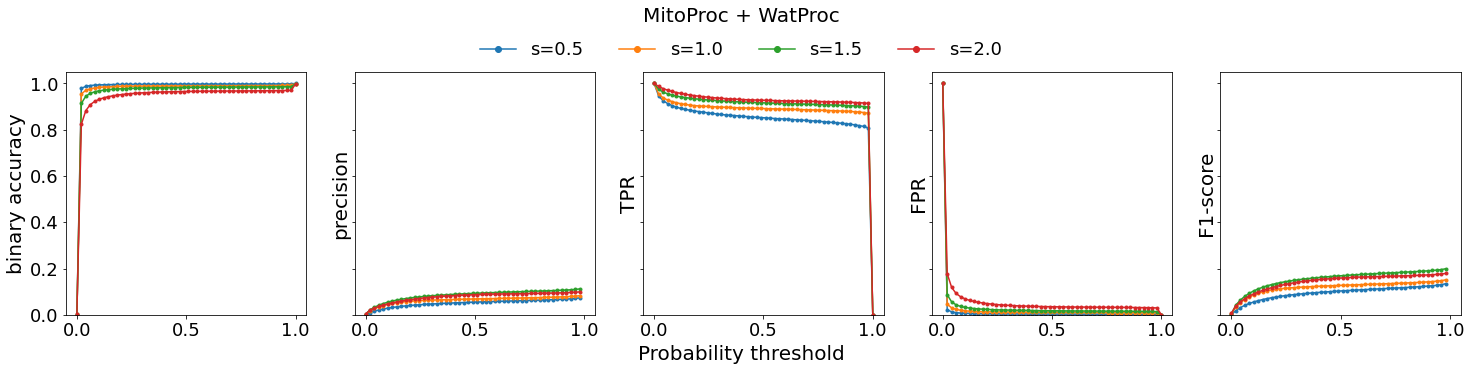

In [23]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f'%s for s in sigmas],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=4, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

##### metricAtMaxThreshold

In [24]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_f8_c9_b16_s0.5  wp_f8_c9_b16_s1.0  wp_f8_c9_b16_s1.5  \
binary accuracy           0.997746           0.991280           0.985879   
precision                 0.073122           0.082605           0.111792   
TPR                       0.807149           0.870892           0.897527   
FPR                       0.002212           0.008612           0.013948   
F1-score                  0.134096           0.150897           0.198820   

                 wp_f8_c9_b16_s2.0  
binary accuracy           0.970063  
precision                 0.099024  
TPR                       0.913295  
FPR                       0.029734  
F1-score                  0.178675

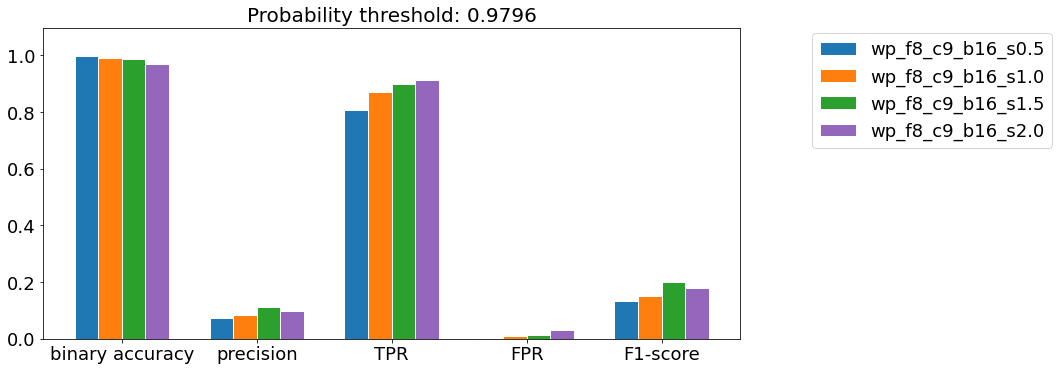

In [25]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

#### MitoProc & WatProc, different spot sizes

In [35]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

sigmas = np.arange(0.5, 2+0.5, 0.5)
nb_sigmas = sigmas.shape[0]

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp_mp')

output_data = {}

for model_name, s in zip(folder_name, sigmas):
  #Outputs
  output_data[model_name] = util.load_h5(data_path, 'WatProc_s'+str(s))

print('Outputs:', output_data[model_name].shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/WatProc_s0.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.0.h5
Converting to array

Loading H:/Santi/Data/WatProc_s1.5.h5
Converting to array

Loading H:/Santi/Data/WatProc_s2.0.h5
Converting to array
Outputs: (37000, 128, 128)


In [36]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, '_s')

nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s0.5/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.0/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.5/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.0/model.h5
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s0.5/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.0/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.5/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.0/history
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s0.5/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.0/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.5/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.0/frames_test
Done.


In [37]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[model_name][frames_test[model_name]]
  del output_data[model_name]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
del input_data

  0%|                                                                        | 0/4 [00:00<?, ?it/s]


Model: wp_mp_f8_c9_b16_s0.5


 25%|████████████████                                                | 1/4 [00:04<00:12,  4.32s/it]


Model: wp_mp_f8_c9_b16_s1.0


 50%|████████████████████████████████                                | 2/4 [00:08<00:08,  4.32s/it]


Model: wp_mp_f8_c9_b16_s1.5


 75%|████████████████████████████████████████████████                | 3/4 [00:12<00:04,  4.29s/it]


Model: wp_mp_f8_c9_b16_s2.0


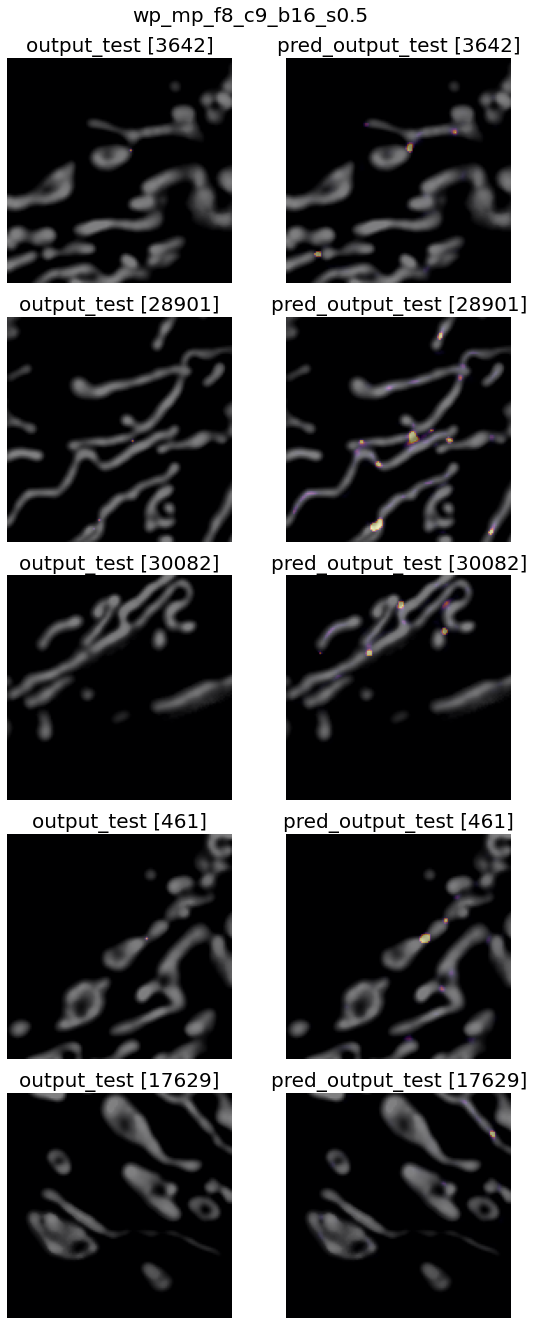

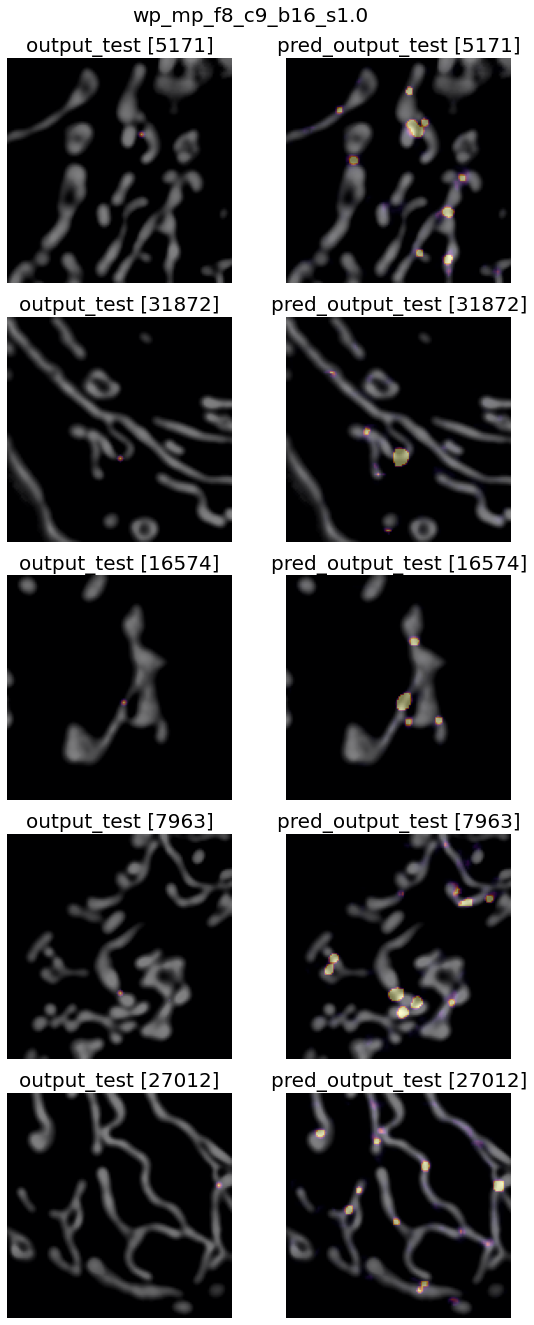

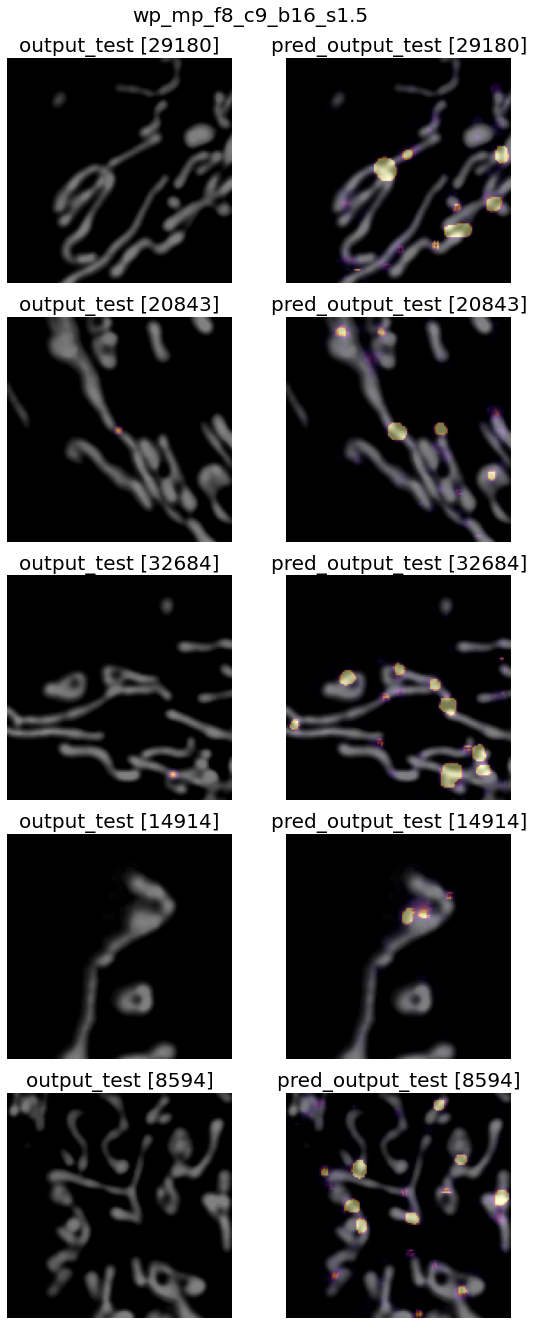

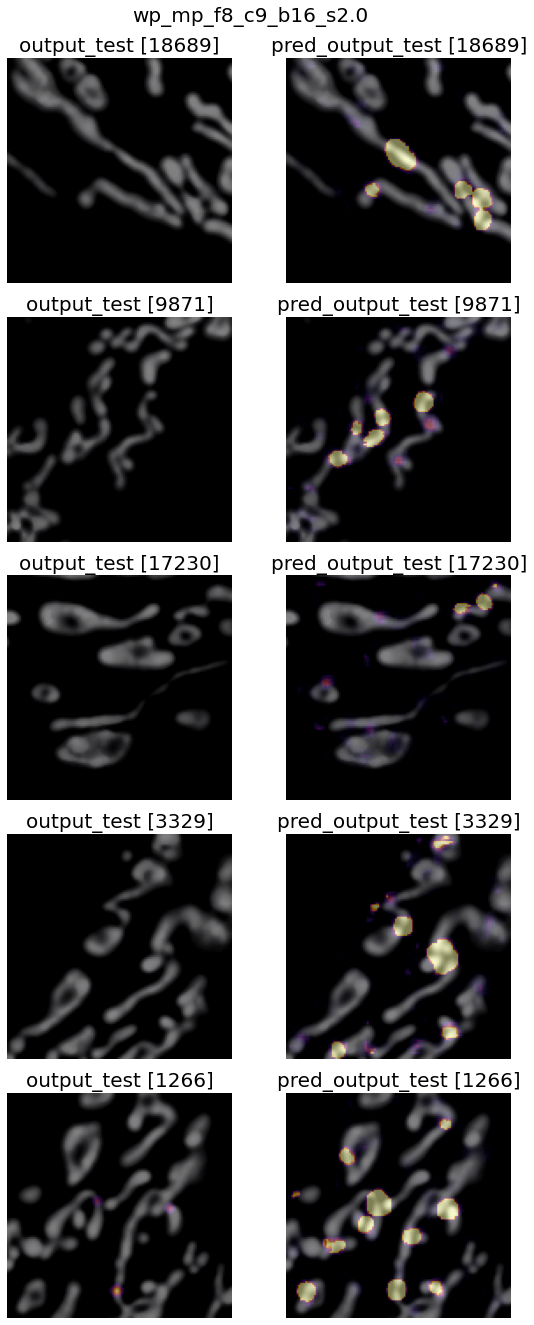

In [38]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [8]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

wp_mp_f8_c9_b16_s0.5: 0.68


C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


wp_mp_f8_c9_b16_s1.0: 0.65


wp_mp_f8_c9_b16_s1.5: 0.62


wp_mp_f8_c9_b16_s2.0: 0.62



Saving H:/Santi/Models/wp_mp_f8_c9_b16_s0.5/metrics

Saving H:/Santi/Models/wp_mp_f8_c9_b16_s1.0/metrics

Saving H:/Santi/Models/wp_mp_f8_c9_b16_s1.5/metrics

Saving H:/Santi/Models/wp_mp_f8_c9_b16_s2.0/metrics
Done.


In [39]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s0.5/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.0/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.5/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.0/metrics
Done.


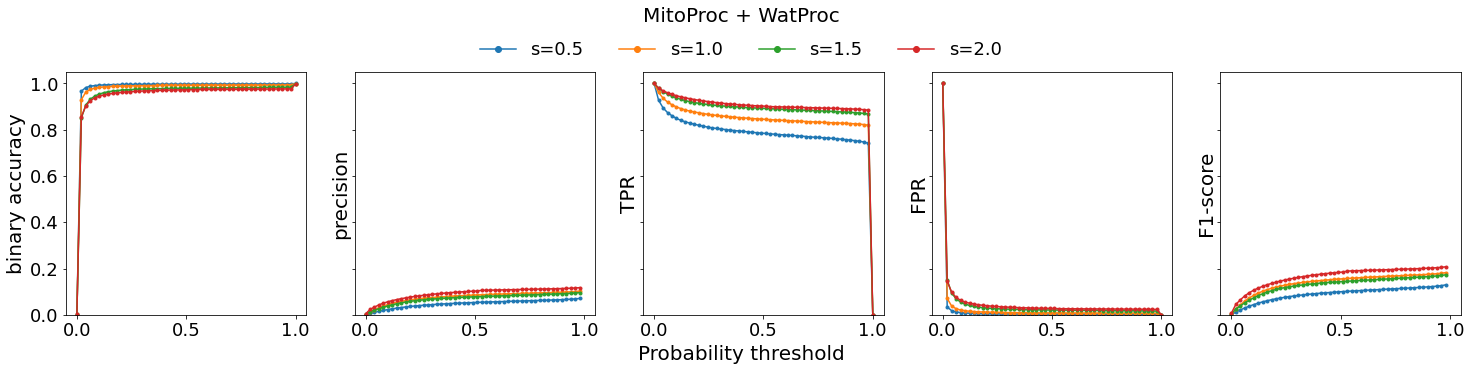

In [40]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f'%s for s in sigmas],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=4, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

##### metricAtMaxThreshold

In [41]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_mp_f8_c9_b16_s0.5  wp_mp_f8_c9_b16_s1.0  \
binary accuracy              0.997860              0.993413   
precision                    0.070783              0.102522   
TPR                          0.741261              0.819173   
FPR                          0.002085              0.006430   
F1-score                     0.129226              0.182236   

                 wp_mp_f8_c9_b16_s1.5  wp_mp_f8_c9_b16_s2.0  
binary accuracy              0.983735              0.976584  
precision                    0.096013              0.117418  
TPR                          0.867537              0.884209  
FPR                          0.016037              0.023095  
F1-score                     0.172891              0.207307

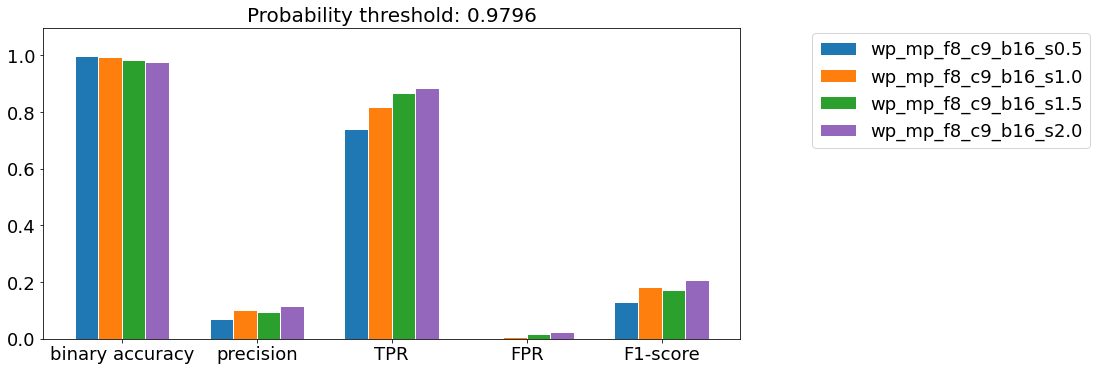

In [42]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

In [61]:
precRecRand = {}
for model_name in folder_name:
  out_binary = output_test[folder_name[0]]>0
  precRecRand[model_name] = out_binary.sum()/(out_binary.size)

print('\nFraction of positives')
print(precRecRand)


Fraction of positives
{'wp_mp_f8_c9_b16_s0.5': 0.00021424989442567568, 'wp_mp_f8_c9_b16_s1.0': 0.00021424989442567568, 'wp_mp_f8_c9_b16_s1.5': 0.00021424989442567568, 'wp_mp_f8_c9_b16_s2.0': 0.00021424989442567568}


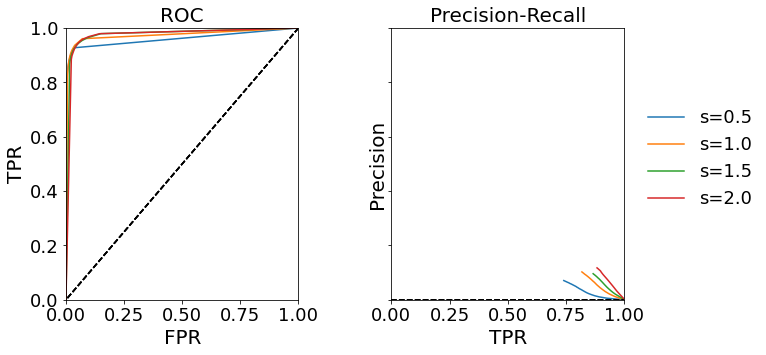

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

for model_name in folder_name:
  axes[0].plot(metrics[model_name]['FPR'], metrics[model_name]['TPR'], label='s=%s'%model_name.split('_s')[-1])
  axes[0].plot(metrics[model_name]['FPR'], metrics[model_name]['FPR'], ls='--', color='black')
  
  axes[1].plot(metrics[model_name]['TPR'], metrics[model_name]['precision'])
  axes[1].axhline(precRecRand[model_name], ls='--', color='black')

axes[0].set_title('ROC', size=20)
axes[0].set(xlabel='FPR', ylabel='TPR')

axes[1].set_title('Precision-Recall', size=20)
axes[1].set(xlabel='TPR', ylabel='Precision')

for ax in axes:
  ax.set(xlim=[0, 1], ylim=[0, 1])
fig.subplots_adjust(wspace=0.4)
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 0.7), framealpha=0)
plt.show()